In [1]:
from dataclasses import dataclass, field
import copy
from enum import Enum, auto
import random
import pandas as pd
import seaborn as sns


import blackjack as bj
from blackjack import Hand, make_hand, HandScore, add_card

In [2]:
h = HandScore(11, True)
h

s11

In [3]:
h.add_card(10)

s21

In [4]:
h.add_card(10).add_card(10)

h21

In [5]:
h

s11

In [6]:
h.add_card(3)

s14

In [7]:
h.add_card(3).add_card(10)

h14

In [8]:
all_scores = [HandScore(i, False) for i in range(0, 23)] + [HandScore(i, True) for i in range(11, 22)]
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [9]:
@dataclass
class Hand:
    """Class for representing a blackjack hand."""
    score: HandScore = HandScore()
    cards: [int] = field(default_factory=list)
    doubled: bool = False

    def add_card(self, card):
        self.score = add_card(self.score, card)
        self.cards += [card]
        return self


In [10]:
h = Hand()
h

Hand(score=h00, cards=[], doubled=False)

In [11]:
h.add_card(6) # start a hand with a 6

Hand(score=h06, cards=[6], doubled=False)

In [12]:
h.add_card(11) # show that J (11) counts as 10 points

Hand(score=h16, cards=[6, 11], doubled=False)

In [13]:
h.add_card(7), bj.is_busted(h) # bust (show that 23 is counted as 22)

(Hand(score=h22, cards=[6, 11, 7], doubled=False), True)

In [14]:
# OK, now let's try another hand with aces
h = Hand()
h.add_card(1) # should be a soft 11

Hand(score=s11, cards=[1], doubled=False)

In [15]:
h.add_card(1) # two aces: should be a soft 12

Hand(score=h12, cards=[1, 1], doubled=False)

In [16]:
h.add_card(11) # two aces and a J: should be a hard 12

Hand(score=h22, cards=[1, 1, 11], doubled=False)

In [17]:
# OK, now let's try another hand with a blackjack
h = Hand()
h.add_card(1) # should be a soft 11
h.add_card(10)
h, bj.is_blackjack(h)

(Hand(score=s21, cards=[1, 10], doubled=False), True)

## Now define gameplay and strategy

In [18]:

# TODO I might want a Flag class later, to provide a set of possible Actions
class Action(Enum):
    STAND = auto()
    HIT = auto()
    DOUBLE = auto()
    #SPLIT = auto()
    
    

In [19]:
# Most simple/conservative strategy imaginable:
def strat_nobust(score_p, _):
    if score_p.points > 11:
        return Action.STAND
    else:
        return Action.HIT
        
strat_nobust.name = 'strat_nobust'

In [20]:
# Dealer strategy
def strat_dealer(score_p, _):
    if score_p.points < 17:
        return Action.HIT
    if score_p.points == 16 and score_p.soft:
        return Action.HIT
    else:
        return Action.STAND
    
strat_dealer.name='strat_dealer'
        

In [21]:
class HandOutcome(Enum):
    WIN = 1
    LOSE = -1
    WIN_DOUBLE = 2
    LOSE_DOUBLE = -2
    PUSH = 0
    BLACKJACK = 1.5

In [22]:
# Deck; completely random (i.e., infinite) for now


def deal_card():
    return random.randrange(13)+1

In [23]:
[deal_card() for _ in range(10)]

[12, 1, 5, 9, 1, 1, 4, 1, 5, 1]

In [24]:
# return the final hand after playing
def player_play_hand(strategy, hand_p, hand_d, deck):
    while True:
        decision = strategy(hand_p.score, hand_d.score)
        if decision == Action.STAND:
            return hand_p
        if decision == Action.HIT:
            hand_p.add_card(deck())
            if bj.is_busted(hand_p):
                return hand_p
        if decision == Action.DOUBLE:
            hand_p.doubled = True
            hand_p.add_card(deck())
            return hand_p



In [25]:
def player_hand_outcome(player_hand, dealer_hand):
    # First compute the initial outcome, then double it if necessary for a double-down
    def initial_outcome():
        if bj.is_blackjack(player_hand):
            if bj.is_blackjack(dealer_hand):
                return HandOutcome.PUSH
            else:
                return HandOutcome.BLACKJACK
        if bj.is_busted(player_hand) or bj.is_blackjack(dealer_hand):
            return HandOutcome.LOSE
        if bj.is_busted(dealer_hand):
            return HandOutcome.WIN
        if player_hand.score.points > dealer_hand.score.points:
            return HandOutcome.WIN
        if player_hand.score.points == dealer_hand.score.points:
            return HandOutcome.PUSH
        if player_hand.score.points < dealer_hand.score.points:
            return HandOutcome.LOSE

    outcome = initial_outcome()

    outcome_doubler = {HandOutcome.WIN: HandOutcome.WIN_DOUBLE, HandOutcome.LOSE: HandOutcome.LOSE_DOUBLE}

    if player_hand.doubled:
        outcome = outcome_doubler.get(outcome) or outcome
    return outcome
        


In [26]:
def get_strat_name(strat):
    if hasattr(strat, 'name'):
        return strat.name
    return repr(strat)

In [27]:
# Goal is to evaluate strategies, so make comparisons simple

# For each round:
# Multiple players all play with a copy of the same starting hand
# Each player has a strategy that they play
# Dealer plays dealer strategy

# For now, we're using an infinite deck and strategies without knowledge, so
# the interaction of players/strategies should be a wash

def deal_one_round():
    hand_p = Hand()
    hand_d = Hand()

    hand_p.add_card(deal_card())
    hand_d.add_card(deal_card())
    hand_p.add_card(deal_card())
    
    dealer_hole_card = deal_card()
    
    return hand_p, hand_d, dealer_hole_card


# Play multiple strategies on one starting point
def complete_one_round(strats, player_hand, dealer_hand, dealer_hole_card):
    hand_p = copy.deepcopy(player_hand)
    hand_d = copy.deepcopy(dealer_hand)
    
    # represent each player as a hand and a strategy
    players = [(player_play_hand(strat, copy.deepcopy(hand_p), hand_d, deal_card), get_strat_name(strat)) for strat in strats]
    
    # dealer
    player_play_hand(strat_dealer, hand_d.add_card(dealer_hole_card), Hand(), deal_card)
    
    return [(strat, hand_p, hand_d, player_hand_outcome(hand_p, hand_d)) for (hand_p, strat) in players]

    
def play_one_round(strats):
    hand_p, hand_d, dealer_hole_card = deal_one_round()
    return complete_one_round(strats, hand_p, hand_d, dealer_hole_card)

play_one_round([strat_nobust, strat_nobust])

[('strat_nobust',
  Hand(score=h12, cards=[1, 1], doubled=False),
  Hand(score=h20, cards=[13, 10], doubled=False),
  <HandOutcome.LOSE: -1>),
 ('strat_nobust',
  Hand(score=h12, cards=[1, 1], doubled=False),
  Hand(score=h20, cards=[13, 10], doubled=False),
  <HandOutcome.LOSE: -1>)]

## Aggregate and summarize the data from the simulations

In [28]:

def generate_row_from_player(player):
    (strat, hand_p, hand_d, outcome) = player
    return {'strategy': strat, 'hand_start': hand_p.cards[:2], 'dealer_card': hand_d.cards[0], 'hand_end': hand_p.cards, 'dealer_hand': hand_d.cards, 'outcome': outcome}

def generate_rows_from_round(r):
    return [generate_row_from_player(player) for player in r]


generate_rows_from_round(play_one_round([strat_nobust, strat_dealer]))


[{'strategy': 'strat_nobust',
  'hand_start': [8, 13],
  'dealer_card': 10,
  'hand_end': [8, 13],
  'dealer_hand': [10, 3, 10],
  'outcome': <HandOutcome.WIN: 1>},
 {'strategy': 'strat_dealer',
  'hand_start': [8, 13],
  'dealer_card': 10,
  'hand_end': [8, 13],
  'dealer_hand': [10, 3, 10],
  'outcome': <HandOutcome.WIN: 1>}]

In [29]:
def run_n_sim_trials(strats, n):
    sims = [generate_rows_from_round(play_one_round(strats)) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

def summarize_totals(sims):
    def outcome_name(x): return x.head(1) # The function name will be used as the column name
    outcome_counts = sims.groupby(['strategy', 'outcome_value'])['outcome_name'].agg([len, outcome_name])
    outcome_summary = outcome_counts.reset_index().set_index('strategy').drop(['outcome_value'], axis=1).pivot(columns=['outcome_name'])

    # The empty cells are NaNs; fill the NaNs and convert back to int
    for col in outcome_summary.columns:
        outcome_summary[col] = outcome_summary[col].fillna(0).apply(int)
        
    outcome_summary['mean_outcome'] = sims.groupby('strategy')['outcome_value'].mean()
    
    return outcome_summary


sim_results = run_n_sim_trials([strat_nobust, strat_dealer], 1000)
sim_results, summarize_totals(sim_results)

(          strategy hand_start  dealer_card          hand_end   dealer_hand  \
 0     strat_nobust    [6, 12]            7           [6, 12]     [7, 7, 4]   
 1     strat_dealer    [6, 12]            7       [6, 12, 13]     [7, 7, 4]   
 2     strat_nobust    [11, 2]            6           [11, 2]     [6, 8, 9]   
 3     strat_dealer    [11, 2]            6        [11, 2, 5]     [6, 8, 9]   
 4     strat_nobust    [2, 10]            6           [2, 10]    [6, 11, 4]   
 ...            ...        ...          ...               ...           ...   
 1995  strat_dealer    [11, 7]            1           [11, 7]       [1, 11]   
 1996  strat_nobust     [9, 5]            8            [9, 5]     [8, 4, 9]   
 1997  strat_dealer     [9, 5]            8         [9, 5, 8]     [8, 4, 9]   
 1998  strat_nobust     [3, 5]            5     [3, 5, 2, 12]  [5, 2, 8, 2]   
 1999  strat_dealer     [3, 5]            5  [3, 5, 3, 1, 12]  [5, 2, 8, 2]   
 
                outcome  outcome_value outcome_nam

In [30]:
def strat_simple(score_p, score_d):
    if score_p.points == 11:  return Action.DOUBLE
    if score_p.points >= 17:  return Action.STAND
    if score_p.points <= 11:  return Action.HIT
    if score_d.points in (range(3,7)):  return Action.STAND
    else:  return Action.HIT
        
strat_simple.name = 'simple'


sims = run_n_sim_trials([strat_simple], 1000)
sims.head(10), summarize_totals(sims)

(  strategy hand_start  dealer_card       hand_end    dealer_hand  \
 0   simple    [11, 5]            4        [11, 5]  [4, 10, 1, 7]   
 1   simple     [8, 3]            4     [8, 3, 12]   [4, 4, 8, 5]   
 2   simple     [2, 2]            1  [2, 2, 12, 4]  [1, 5, 7, 10]   
 3   simple    [8, 10]            1        [8, 10]         [1, 6]   
 4   simple     [8, 6]           13     [8, 6, 11]       [13, 13]   
 5   simple   [11, 12]            1       [11, 12]   [1, 3, 3, 1]   
 6   simple    [12, 8]            3        [12, 8]   [3, 8, 4, 4]   
 7   simple    [1, 10]            6        [1, 10]    [6, 10, 11]   
 8   simple    [13, 5]            4        [13, 5]  [4, 2, 6, 11]   
 9   simple    [11, 6]            1    [11, 6, 10]        [1, 13]   
 
                  outcome  outcome_value outcome_name  
 0        HandOutcome.WIN            1.0          WIN  
 1       HandOutcome.PUSH            0.0         PUSH  
 2        HandOutcome.WIN            1.0          WIN  
 3        HandO

In [31]:
summarize_totals(run_n_sim_trials([strat_dealer, strat_nobust, strat_simple], 10000))


len                                         mean_outcome
outcome_name BLACKJACK  LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                                   
simple             459  4648         256  865  3443        329     -0.03705
strat_dealer       459  4954           0  959  3628          0     -0.06375
strat_nobust       459  5169           0  630  3742          0     -0.07385

## Simulate specific situations to determine strategy

In [32]:
def make_hand(cards):
    h = Hand()
    for c in cards:
        h = h.add_card(c)
    return h

In [33]:
# 12 vs deuce

hand_p = make_hand([5, 7])
hand_d = make_hand([2])

hand_p, hand_d

(Hand(score=h12, cards=[5, 7], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [34]:
# Implement a strategy that composes conditions and actions

def cond_12_2(score_p, score_d):
    return score_p.points == 12 and score_d.points == 2 and not score_p.soft
conditions = [(cond_12_2, Action.STAND)]

def generate_strat_conditional(strat_base, conditions):
    def strat_cond(score_p, score_d):
        for (condition, action) in conditions:
            if condition(score_p, score_d): return action
        return strat_base(score_p, score_d)
    strat_cond.name = 'strat_cond'
    return strat_cond
    
strat_cond = generate_strat_conditional(strat_simple, conditions)

In [35]:
def gen_cond_strategies(strat_base, condition, actions):
    def gen_strat_action(strat_base, condition, action):
        strat = generate_strat_conditional(strat_base, [(condition, action)])
        strat.name = repr(action)
        return strat
    
    strats = [gen_strat_action(strat_base, condition, a) for a in actions]
    return strats
    



strats = gen_cond_strategies(strat_simple, cond_12_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [36]:
complete_one_round(strats, hand_p, hand_d, deal_card())

[('<Action.HIT: 2>',
  Hand(score=h20, cards=[5, 7, 8], doubled=False),
  Hand(score=h22, cards=[2, 8, 6, 13], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.STAND: 1>',
  Hand(score=h12, cards=[5, 7], doubled=False),
  Hand(score=h22, cards=[2, 8, 6, 13], doubled=False),
  <HandOutcome.WIN: 1>),
 ('<Action.DOUBLE: 3>',
  Hand(score=h15, cards=[5, 7, 3], doubled=True),
  Hand(score=h22, cards=[2, 8, 6, 13], doubled=False),
  <HandOutcome.WIN_DOUBLE: 2>)]

In [37]:
# TODO reduce duplication with run_n_sim_trials
def run_n_sim_trials_from_state(strats, hand_p, hand_d, n):
    sims = [generate_rows_from_round(complete_one_round(strats, hand_p, hand_d, deal_card())) for _ in range(n)]
    results = pd.DataFrame([player for round in sims for player in round])
    results['outcome_value'] = results['outcome'].apply(lambda x: x.value)
    results['outcome_name'] = results['outcome'].apply(lambda x: str(x)[12:])
    return results

sims = run_n_sim_trials_from_state(strats, hand_p, hand_d, 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        6013  476     0       3511      -0.5004
<Action.HIT: 2>     6118           0  666  3216          0      -0.2902
<Action.STAND: 1>   6382           0    0  3618          0      -0.2764

In [38]:
# Soft 12 vs 2
hand_12s = make_hand([1, 1])

hand_12s, hand_d

(Hand(score=h12, cards=[1, 1], doubled=False),
 Hand(score=h02, cards=[2], doubled=False))

In [39]:
def cond_12s_2(score_p, score_d):
    return score_p == HandScore(12, True) and score_d.points == 2

strats = gen_cond_strategies(strat_simple, cond_12s_2, [Action.HIT, Action.STAND, Action.DOUBLE])
strats

[<function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>,
 <function __main__.generate_strat_conditional.<locals>.strat_cond(score_p, score_d)>]

In [40]:
sims = run_n_sim_trials_from_state(strats+[strat_simple], hand_12s, hand_d, 10000)
summarize_totals(sims)

len            mean_outcome
outcome_name        LOSE PUSH   WIN             
strategy                                        
<Action.DOUBLE: 3>  6146  651  3203      -0.2943
<Action.HIT: 2>     6069  672  3259      -0.2810
<Action.STAND: 1>   6027  659  3314      -0.2713
simple              6083  685  3232      -0.2851

In [41]:
summarize_totals(run_n_sim_trials_from_state([strat_simple, strat_cond], hand_p, hand_d, 10*1000))

len            mean_outcome
outcome_name  LOSE PUSH   WIN             
strategy                                  
simple        6113  679  3208      -0.2905
strat_cond    6478    0  3522      -0.2956

In [42]:
# soft 13 vs 6
def cond_13s_6(score_p, score_d):
    return score_p == HandScore(13, True) and score_d.points == 6



strats = gen_cond_strategies(strat_simple, cond_13s_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], bj.make_hand([1, 2]), bj.make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        5830    0     0       4170      -0.3320
<Action.HIT: 2>     4553         331  287  4114        715       0.0329
<Action.STAND: 1>   5830           0    0  4170          0      -0.1660
simple              5830           0    0  4170          0      -0.1660

In [43]:
# 10 v 6
def cond_10_6(score_p, score_d):
    return score_p.points == 10 and score_d.points == 6

strats = gen_cond_strategies(strat_simple, cond_10_6, [Action.HIT, Action.STAND, Action.DOUBLE])
sims = run_n_sim_trials_from_state(strats+[strat_simple], make_hand([5, 5]), make_hand([6]), 10000)
summarize_totals(sims)

len                                   mean_outcome
outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
strategy                                                               
<Action.DOUBLE: 3>     0        3200  692     0       6108       0.5816
<Action.HIT: 2>     3144           0  720  6136          0       0.2992
<Action.STAND: 1>   5739           0    0  4261          0      -0.1478
simple              3166           0  700  6134          0       0.2968

In [44]:
ACTIONS = [Action.HIT, Action.STAND, Action.DOUBLE]

def test_cond(score_p, score_d, n):
    def cond(p, d):
        return p == score_p and d == score_d
    strats = gen_cond_strategies(strat_simple, cond, ACTIONS)
    hand = Hand(score_p) # This will only work for 10 through 18 
    sims = run_n_sim_trials_from_state(strats, hand, make_hand([score_d.points]), n)
    return cond, summarize_totals(sims)

test_cond(HandScore(10), HandScore(6), 10000)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                      len                                   mean_outcome
 outcome_name        LOSE LOSE_DOUBLE PUSH   WIN WIN_DOUBLE             
 strategy                                                               
 <Action.DOUBLE: 3>     0        3212  712     0       6076       0.5728
 <Action.HIT: 2>     3269           0  636  6095          0       0.2826
 <Action.STAND: 1>   5754           0    0  4246          0      -0.1508)

In [45]:
test_cond(HandScore(18), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0         163    3    0         34        -1.29
 <Action.HIT: 2>     162           0    6   32          0        -0.65
 <Action.STAND: 1>    66           0   26  108          0         0.21)

In [46]:
test_cond(HandScore(21, True), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
                     len                                  mean_outcome
 outcome_name       LOSE LOSE_DOUBLE PUSH  WIN WIN_DOUBLE             
 strategy                                                             
 <Action.DOUBLE: 3>    0          61   14    0        125        0.640
 <Action.HIT: 2>      54           0   13  133          0        0.395
 <Action.STAND: 1>     0           0   15  185          0        0.925)

In [47]:
all_scores

[h00,
 h01,
 h02,
 h03,
 h04,
 h05,
 h06,
 h07,
 h08,
 h09,
 h10,
 h11,
 h12,
 h13,
 h14,
 h15,
 h16,
 h17,
 h18,
 h19,
 h20,
 h21,
 h22,
 s11,
 s12,
 s13,
 s14,
 s15,
 s16,
 s17,
 s18,
 s19,
 s20,
 s21]

In [48]:
def find_winning_action(score_p, score_d, n):
    cond, summary = test_cond(score_p, score_d, n)
    outcomes = summary['mean_outcome']
    # Find the winning strategy
    winner = outcomes[outcomes==outcomes.max()].index[0]
    winning_act = [a for a in ACTIONS if repr(a)==winner][0]

    # Convert results to a dict
    run = outcomes.to_dict()
    run['score_p'] = repr(score_p)
    run['score_d'] = repr(score_d)
    run['winning_act'] = winning_act
    run['winning_act_outcome'] = outcomes.max()

    return (cond, run)

find_winning_action(HandScore(10), HandScore(6), 200)

(<function __main__.test_cond.<locals>.cond(p, d)>,
 {'<Action.DOUBLE: 3>': 0.46,
  '<Action.HIT: 2>': 0.13,
  '<Action.STAND: 1>': -0.3,
  'score_p': 'h10',
  'score_d': 'h06',
  'winning_act': <Action.DOUBLE: 3>,
  'winning_act_outcome': 0.46})

In [49]:
conds = [find_winning_action(p, make_hand([d]).score, 10) for p in all_scores for d in range(1, 3)]
pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h00     s11                   -0.60             0.25              -0.20   
        h02                    0.80             0.00               0.40   
h01     s11                   -0.35            -0.20              -0.95   
        h02                   -0.80            -0.05              -0.40   
h02     s11                    0.50             0.10               0.30   
...                             ...              ...                ...   
s19     h02                    0.00             0.40               0.30   
s20     s11                    0.50             0.50               0.50   
        h02                    0.80             0.65               0.80   
s21     s11                    1.00             1.00               1.00   
        h02                    0.80             0.40               1.00   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h00     s11         Action.HIT                 0.25  
        h02      Action.DOUBLE                 0.80  
h01     s11         Action.HIT                -0.20  
        h02         Action.HIT                -0.05  
h02     s11      Action.DOUBLE                 0.50  
...                        ...                  ...  
s19     h02         Action.HIT                 0.40  
s20     s11      Action.DOUBLE                 0.50  
        h02      Action.DOUBLE                 0.80  
s21     s11      Action.DOUBLE                 1.00  
        h02       Action.STAND                 1.00  

[68 rows x 5 columns]

In [50]:
conds = [find_winning_action(HandScore(p), make_hand([d]).score, 1*1000) for p in range(10, 19) for d in range(1, 11)]
conds

[(<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': -0.033,
   '<Action.HIT: 2>': -0.0455,
   '<Action.STAND: 1>': -0.065,
   'score_p': 'h10',
   'score_d': 's11',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': -0.033}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.388,
   '<Action.HIT: 2>': 0.2145,
   '<Action.STAND: 1>': -0.286,
   'score_p': 'h10',
   'score_d': 'h02',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.388}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.416,
   '<Action.HIT: 2>': 0.228,
   '<Action.STAND: 1>': -0.234,
   'score_p': 'h10',
   'score_d': 'h03',
   'winning_act': <Action.DOUBLE: 3>,
   'winning_act_outcome': 0.416}),
 (<function __main__.test_cond.<locals>.cond(p, d)>,
  {'<Action.DOUBLE: 3>': 0.58,
   '<Action.HIT: 2>': 0.265,
   '<Action.STAND: 1>': -0.148,
   'score_p': 'h10',
   'score_d': 'h04',
   'winning_act': <Action

In [51]:
outputs = pd.DataFrame([data for _, data in conds]).set_index(['score_p', 'score_d'])
outputs

<Action.DOUBLE: 3>  <Action.HIT: 2>  <Action.STAND: 1>  \
score_p score_d                                                           
h10     s11                  -0.033          -0.0455             -0.065   
        h02                   0.388           0.2145             -0.286   
        h03                   0.416           0.2280             -0.234   
        h04                   0.580           0.2650             -0.148   
        h05                   0.652           0.2940             -0.140   
...                             ...              ...                ...   
h18     h06                  -1.218          -0.6190              0.296   
        h07                  -1.126          -0.5520              0.418   
        h08                  -1.172          -0.5630              0.109   
        h09                  -1.206          -0.6140             -0.166   
        h10                  -1.358          -0.6650             -0.282   

                   winning_act  winning_act_outcome  
score_p score_d                                      
h10     s11      Action.DOUBLE               -0.033  
        h02      Action.DOUBLE                0.388  
        h03      Action.DOUBLE                0.416  
        h04      Action.DOUBLE                0.580  
        h05      Action.DOUBLE                0.652  
...                        ...                  ...  
h18     h06       Action.STAND                0.296  
        h07       Action.STAND                0.418  
        h08       Action.STAND                0.109  
        h09       Action.STAND               -0.166  
        h10       Action.STAND               -0.282  

[90 rows x 5 columns]

<AxesSubplot:xlabel='score_d', ylabel='score_p'>

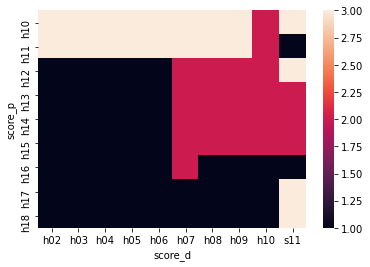

In [52]:
# Visualize the winning action by starting condition
sns.heatmap(outputs['winning_act'].apply(lambda x: x.value).unstack())


<AxesSubplot:xlabel='score_d', ylabel='score_p'>

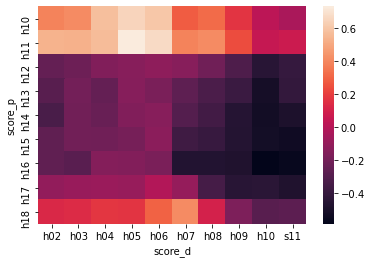

In [53]:
# Visualize the average outcome by starting condition
sns.heatmap(outputs['winning_act_outcome'].unstack())

In [54]:
[(cond, output['winning_act']) for cond, output in conds]

[(<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.HIT: 2>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.STAND: 1>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.cond(p, d)>, <Action.DOUBLE: 3>),
 (<function __main__.test_cond.<locals>.co

In [55]:
strat_derived = generate_strat_conditional(strat_simple, [(cond, output['winning_act']) for cond, output in conds])
strat_derived.name = 'strat_derived'

In [56]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card          hand_end  dealer_hand  \
 0         simple    [1, 13]            2           [1, 13]   [2, 13, 8]   
 1  strat_derived    [1, 13]            2           [1, 13]   [2, 13, 8]   
 2         simple    [3, 11]            4           [3, 11]   [4, 13, 9]   
 3  strat_derived    [3, 11]            4           [3, 11]   [4, 13, 9]   
 4         simple     [5, 2]           12        [5, 2, 12]      [12, 9]   
 5  strat_derived     [5, 2]           12     [5, 2, 7, 12]      [12, 9]   
 6         simple     [3, 3]            6        [3, 3, 12]   [6, 10, 8]   
 7  strat_derived     [3, 3]            6  [3, 3, 2, 3, 10]   [6, 10, 8]   
 8         simple    [1, 11]           10           [1, 11]  [10, 2, 10]   
 9  strat_derived    [1, 11]           10           [1, 11]  [10, 2, 10]   
 
                   outcome  outcome_value outcome_name  
 0   HandOutcome.BLACKJACK            1.5    BLACKJACK  
 1   HandOutcome.BLACKJACK            1.5    BLA

In [57]:
sims = run_n_sim_trials([strat_simple, strat_derived], 100*1000)
sims.head(10), summarize_totals(sims)

(        strategy hand_start  dealer_card     hand_end       dealer_hand  \
 0         simple   [11, 11]           10     [11, 11]           [10, 8]   
 1  strat_derived   [11, 11]           10     [11, 11]           [10, 8]   
 2         simple    [13, 2]            2  [13, 2, 10]         [2, 9, 6]   
 3  strat_derived    [13, 2]            2      [13, 2]         [2, 9, 6]   
 4         simple     [7, 6]            4       [7, 6]         [4, 7, 8]   
 5  strat_derived     [7, 6]            4       [7, 6]         [4, 7, 8]   
 6         simple     [5, 6]           13    [5, 6, 6]          [13, 13]   
 7  strat_derived     [5, 6]           13    [5, 6, 5]          [13, 13]   
 8         simple     [3, 7]            1   [3, 7, 11]  [1, 3, 2, 4, 11]   
 9  strat_derived     [3, 7]            1    [3, 7, 7]  [1, 3, 2, 4, 11]   
 
                    outcome  outcome_value outcome_name  
 0          HandOutcome.WIN            1.0          WIN  
 1          HandOutcome.WIN            1.0    